In [3]:
import sys
sys.path.append('/home/lpsha/s154446/fractality/dual_graph_algo/')

import dual_conti

from importlib import reload
reload(dual_conti)

import pandas as pd
import geopandas as gpd

from pyrosm import OSM, get_data
import osmnx as ox
import momepy

import matplotlib.pyplot as plt
import numpy as np
import powerlaw

from importlib import reload
reload(dual_conti)

plt.rcParams['font.size'] = 14
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['axes.linewidth'] = 1.2
plt.rcParams['figure.dpi'] = 150
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.size'] = 6
plt.rcParams['ytick.major.size'] = 6
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['ytick.minor.size'] = 3
plt.rcParams['axes.titlepad'] = 10

In [4]:
gdf = ox.geocode_to_gdf("Berlin, Germany")
G = ox.graph.graph_from_polygon(gdf.geometry[0], network_type='all')

In [ ]:
gdf_merged, _, _, _ = dual_conti.get_dual_dir_con(t_buffer=10, a_threshold=20, data=G, enforce_degree2=False)
gdf_merged['degree_log'] = np.log10(gdf_merged['degree'])

osmnx graph


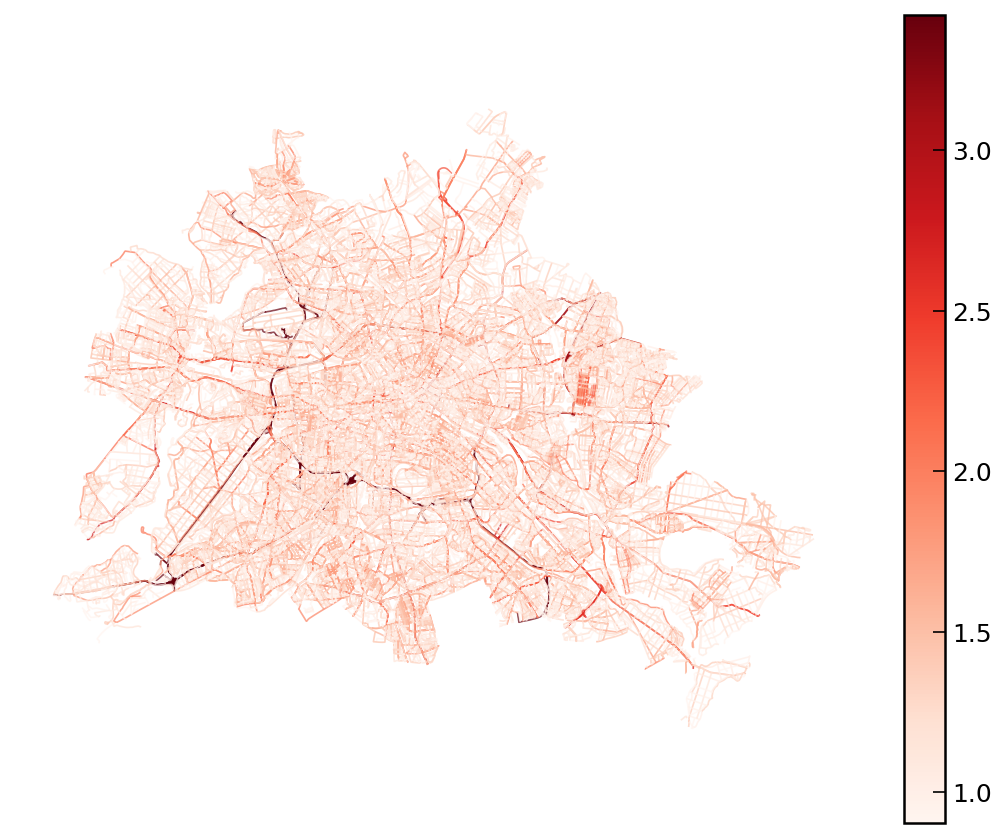

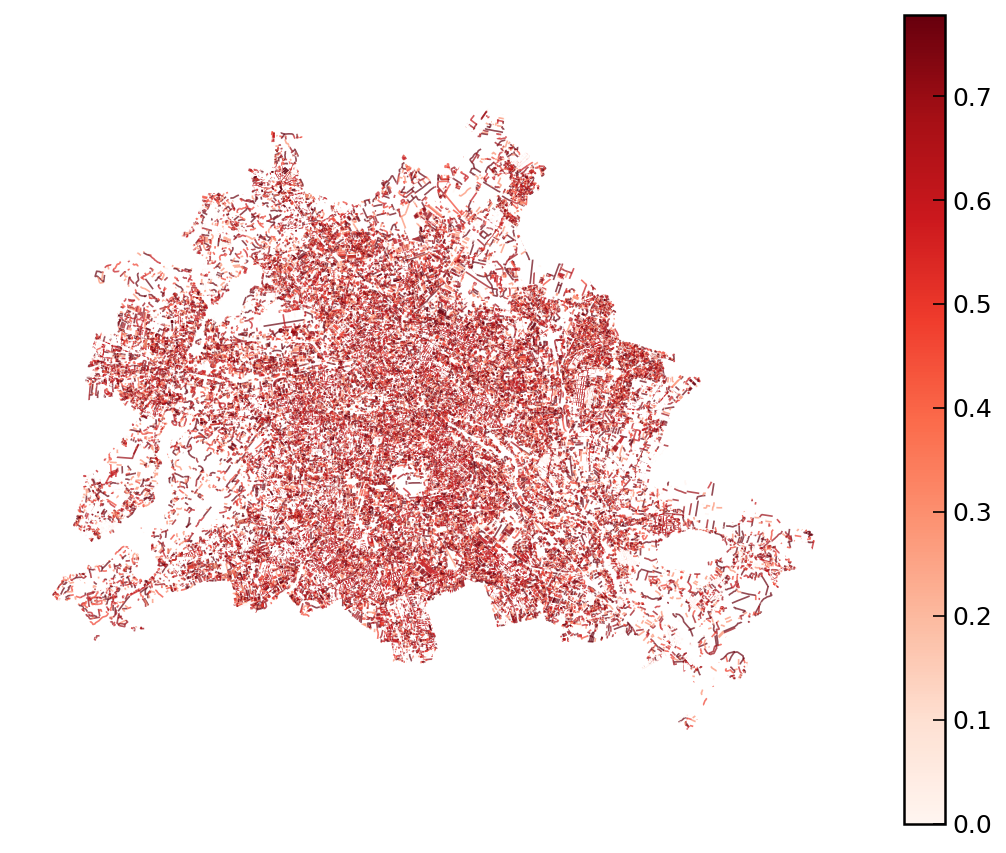

In [15]:
fig, ax = plt.subplots(figsize=(9, 7))
gdf_merged.loc[gdf_merged['degree'] > 7].plot(column='degree_log', cmap='Reds', legend=True, ax=ax,linewidth=0.8,alpha=0.7)
ax.axis('off')
plt.show()

fig, ax = plt.subplots(figsize=(9, 7))
gdf_merged.loc[gdf_merged['degree'] < 7].plot(column='degree_log', cmap='Reds', legend=True, ax=ax,linewidth=0.8,alpha=0.7)
ax.axis('off')
plt.show()

In [16]:
print(len(gdf_merged.loc[gdf_merged['degree'] < 7]),len(gdf_merged.loc[gdf_merged['degree'] > 7]))

154879 35396


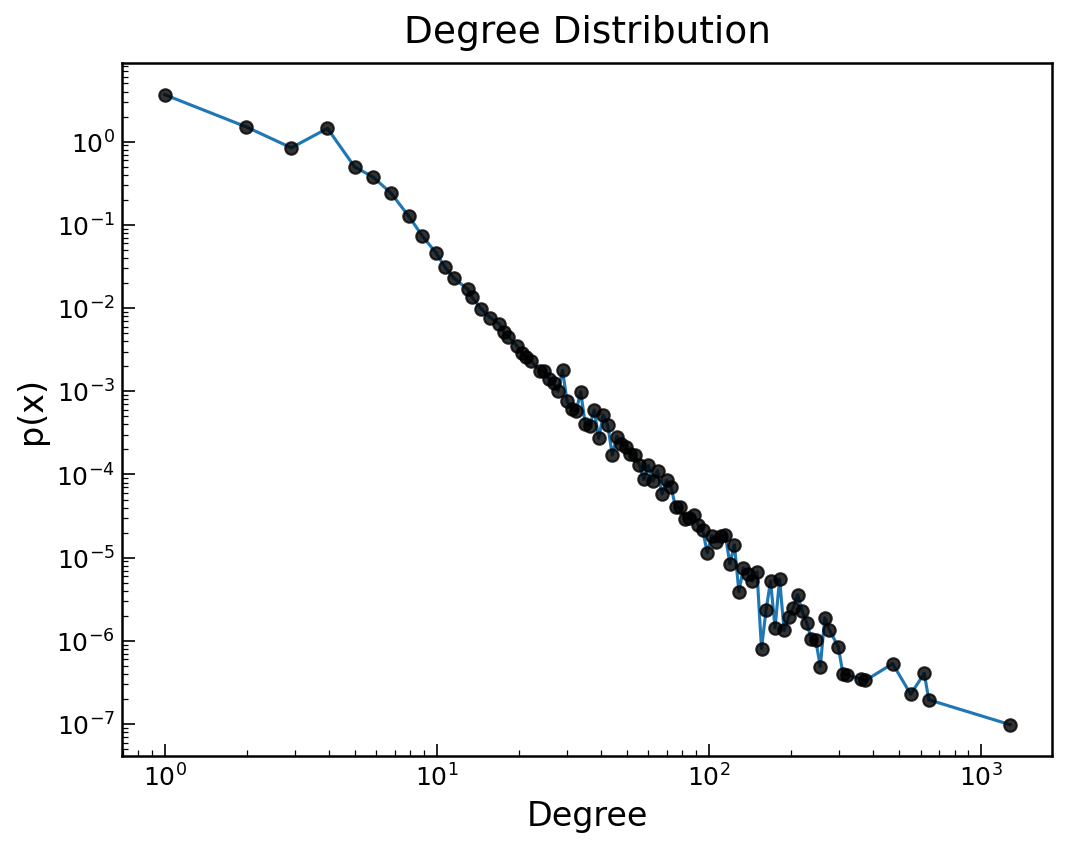

In [11]:
fig, ax = plt.subplots(figsize=(8, 6))
degree_obs_val = gdf_merged['degree'].values
y, x = np.histogram(degree_obs_val, bins=np.logspace(0, np.log10(degree_obs_val.max()), len(np.unique(degree_obs_val))), density=True)
x = x[:-1]
x_nn = x[y != 0][:-1]
y_nn = y[y != 0][:-1]
ax.scatter(x_nn, y_nn, alpha=0.8, zorder=3, color='k')
ax.plot(x_nn, y_nn, alpha=1, zorder=2)
ax.set_ylabel('p(x)')
ax.set_xlabel('Degree')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title("Degree Distribution")
plt.show()

# input Pyrosm vs OSMNX

In [ ]:
fp = get_data('Isle of Man')
osm = OSM(fp)
_, shape_df = osm.get_network(nodes=True)
gdf_merged, H = dual_conti.get_dual_dir_con(t_buffer=5, a_threshold=30, data=shape_df, enforce_degree2=False)

pyrosm GeoDataFrame


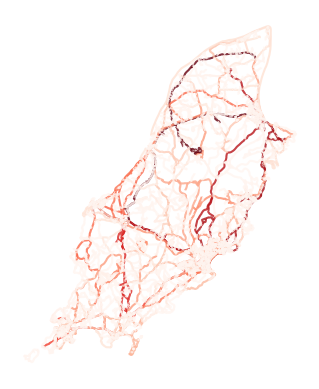

In [67]:
gdf_merged['degree_log'] = gdf_merged['degree'].apply(np.log10)
gdf_merged.plot(column='degree_log',vmin=1,cmap='Reds',alpha=0.8)
plt.axis('off')
plt.show()

In [ ]:
place_name = "Isle of Man"
G = ox.graph_from_place(place_name, network_type="all")
gdf_merged_ox, H = dual_conti.get_dual_dir_con(t_buffer=5, a_threshold=30, data=G, enforce_degree2=False)

osmnx graph


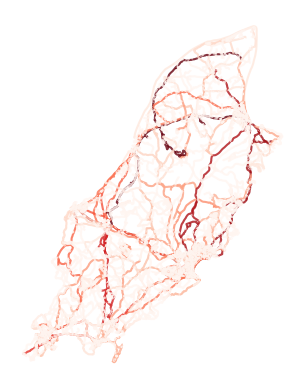

In [69]:
gdf_merged_ox['degree_log'] = gdf_merged_ox['degree'].apply(np.log10)
gdf_merged_ox.plot(column='degree_log',vmin=1,cmap='Reds',alpha=0.8)
plt.axis('off')
plt.show()

In [79]:
def compute_ks(degree,min_range):
    distance = []
    for i_min in min_range:
        fit = powerlaw.Fit(degree,discrete=True,xmin=i_min)
        a = fit.alpha
        xmin = fit.xmin
        x_fit = degree[degree>xmin]
        distance.append(fit.power_law.D)

    return np.array(distance), min_range

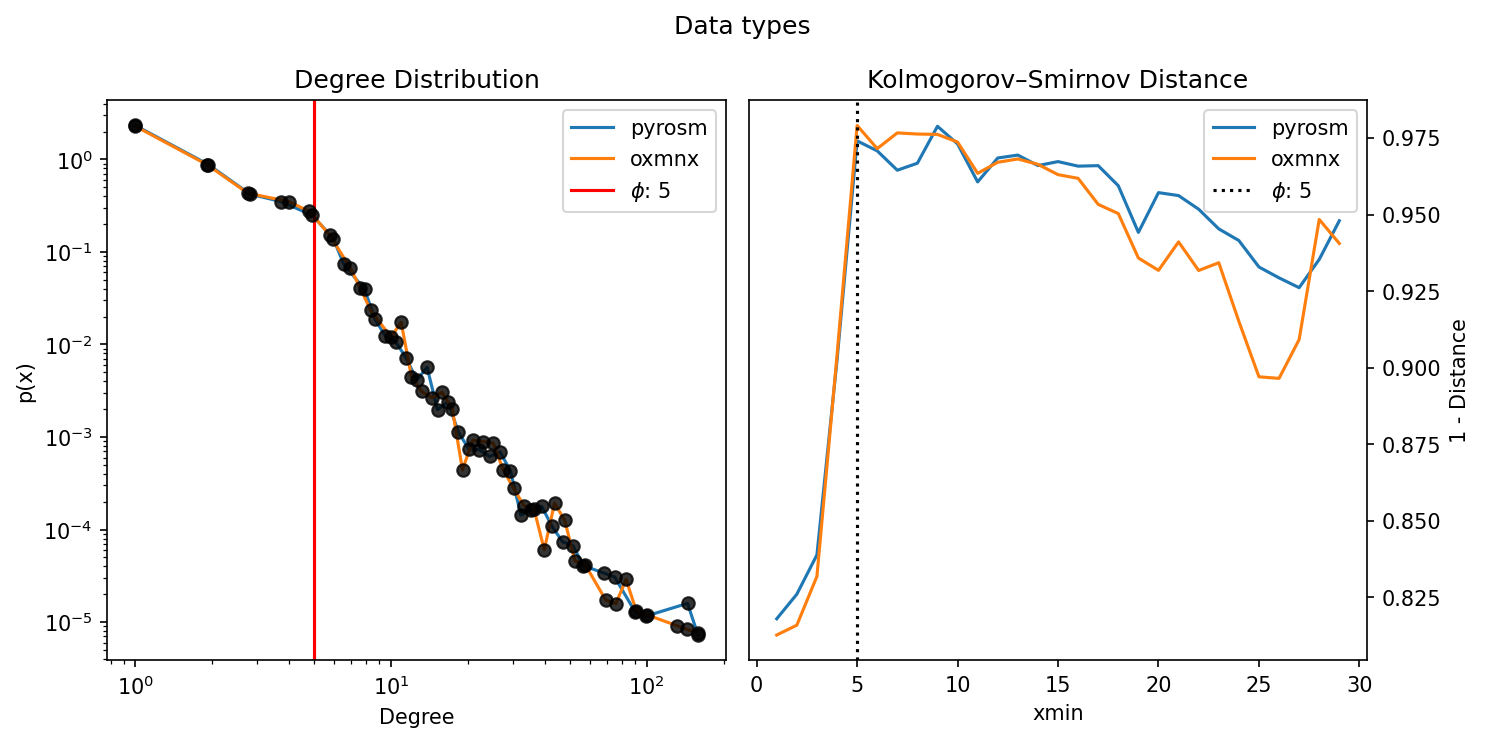

In [ ]:
ps = 5

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5),dpi=150)
axs = axs.ravel()
ax = axs[0]

d_type = ['pyrosm','oxmnx',]

# Histogram data
for enu, degree_obs_val in enumerate([gdf_merged.degree.values, gdf_merged_ox.degree.values]):
    
    y, x = np.histogram(degree_obs_val, bins=np.logspace(0, np.log10(degree_obs_val.max()), len(np.unique(degree_obs_val))), density=True)
    x = x[:-1]
    x_nn = x[y != 0][:-1]
    y_nn = y[y != 0][:-1]
    ax.scatter(x_nn, y_nn, alpha=0.8, zorder=3, color='k')
    ax.plot(x_nn, y_nn, alpha=1, zorder=2,label=d_type[enu])
    ax.set_ylabel('p(x)')
    ax.set_xlabel('Degree')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title("Degree Distribution")

    ks_dist, xmins = compute_ks(degree_obs_val[degree_obs_val!=0], range(1,30))
    ax2 = axs[1]
    # ax2.scatter(xmins,1-ks_dist,color='red')
    ax2.plot(xmins,1-ks_dist,label=d_type[enu])
    ax2.set_xlabel('xmin')
    ax2.set_ylabel('1 - Distance')
    ax2.yaxis.tick_right()
    ax2.yaxis.set_label_position("right")
    ax2.set_title('Kolmogorov–Smirnov Distance')

ax.axvline(ps,label=f'$\phi$: {ps}',color='red')
ax2.axvline(ps,color='k',linestyle='dotted',label='$\phi$: '+str(ps))
ax2.legend()
ax.legend()

plt.suptitle('Data types')
plt.tight_layout()
plt.show()

In [106]:
print(len(gdf_merged))
print(len(gdf_merged_ox))

8895
8615


# Frederiksberg

In [34]:
from importlib import reload
reload(dual_conti)

<module 'dual_conti' from '/home/lpsha/s154446/fractality/dual_graph_algo/dual_conti.py'>

In [35]:
place_name = "Frederiksberg Municipality, Denmark"
G = ox.graph_from_place(place_name, network_type="all")  
gdf_merged_ox, H, _, _ = dual_conti.get_dual_dir_con(t_buffer=10, a_threshold=30, data=G,enforce_degree2=False)

osmnx graph


/home/lpsha/.conda/envs/umap-env/lib/python3.10/site-packages/momepy/preprocessing.py:771: FutureWarning: Class based API like `momepy.CircularCompactness` is deprecated. Replace it with `momepy.circular_compactness` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  circom_serie = CircularCompactness(gdf, area_col).series


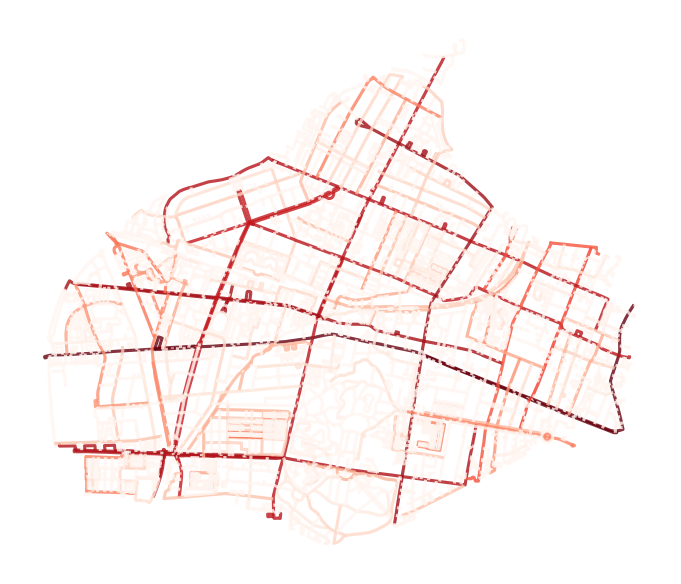

In [36]:
gdf_merged_ox['degree_log'] = gdf_merged_ox['degree'].apply(np.log10)
gdf_merged_ox.plot(column='degree_log',cmap='Reds',alpha=0.8,vmin=1)
plt.axis('off')
plt.show()

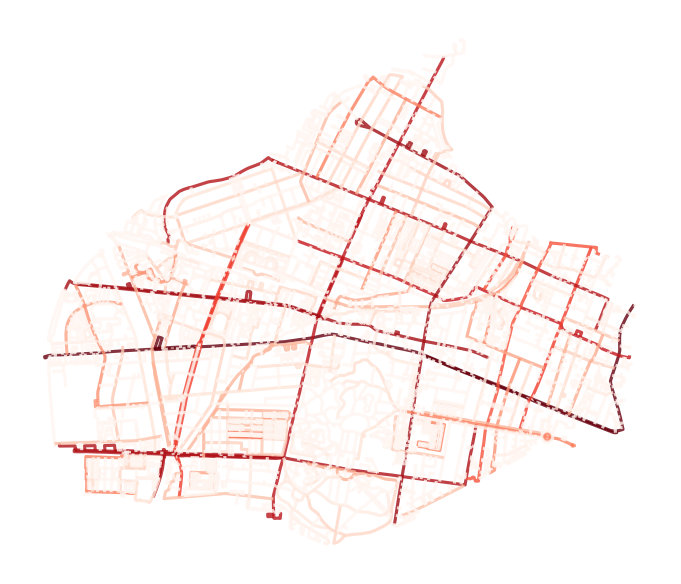

In [25]:
gdf_merged_ox['degree_log'] = gdf_merged_ox['degree'].apply(np.log10)
gdf_merged_ox.plot(column='degree_log',cmap='Reds',alpha=0.8,vmin=1)
plt.axis('off')
plt.show()

In [11]:
place = "Chamberi, Madrid"

G = ox.graph_from_place(place, network_type="drive", simplify=True)
G_projected = ox.project_graph(G)

edges = ox.graph_to_gdfs(
    ox.convert.to_undirected(
        G_projected
    ),  # prevents some (semi)duplicate geometries
    nodes=False,
    edges=True,
    node_geometry=False,
    fill_edge_geometry=True,
)

edges.head(3)

osmid  highway lanes maxspeed  \
u         v         key                                      
22022145  630734756 0      4950643  primary     4       50   
630734756 22022227  0      4950641  primary     4       50   
          141870722 0    131450468  primary     4       50   

                                       name  oneway  reversed     length  \
u         v         key                                                    
22022145  630734756 0     Calle de Carranza    True     False  73.159523   
630734756 22022227  0    Glorieta de Bilbao    True     False  38.431267   
          141870722 0    Glorieta de Bilbao    True     False  20.976139   

                                                                  geometry  \
u         v         key                                                      
22022145  630734756 0    LINESTRING (440346.763 4475626.335, 440393.752...   
630734756 22022227  0    LINESTRING (440417.448 4475607.745, 440425.289...   
          141870722 0    LINESTRING (440411.787 4475627.727, 440413.3 4...   

                              from         to width access tunnel junction  
u         v         key                                                     
22022145  630734756 0     22022145  630734756   NaN    NaN    NaN      NaN  
630734756 22022227  0    630734756   22022227   NaN    NaN    NaN      NaN  
          141870722 0    141870722  630734756   NaN    NaN    NaN      NaN

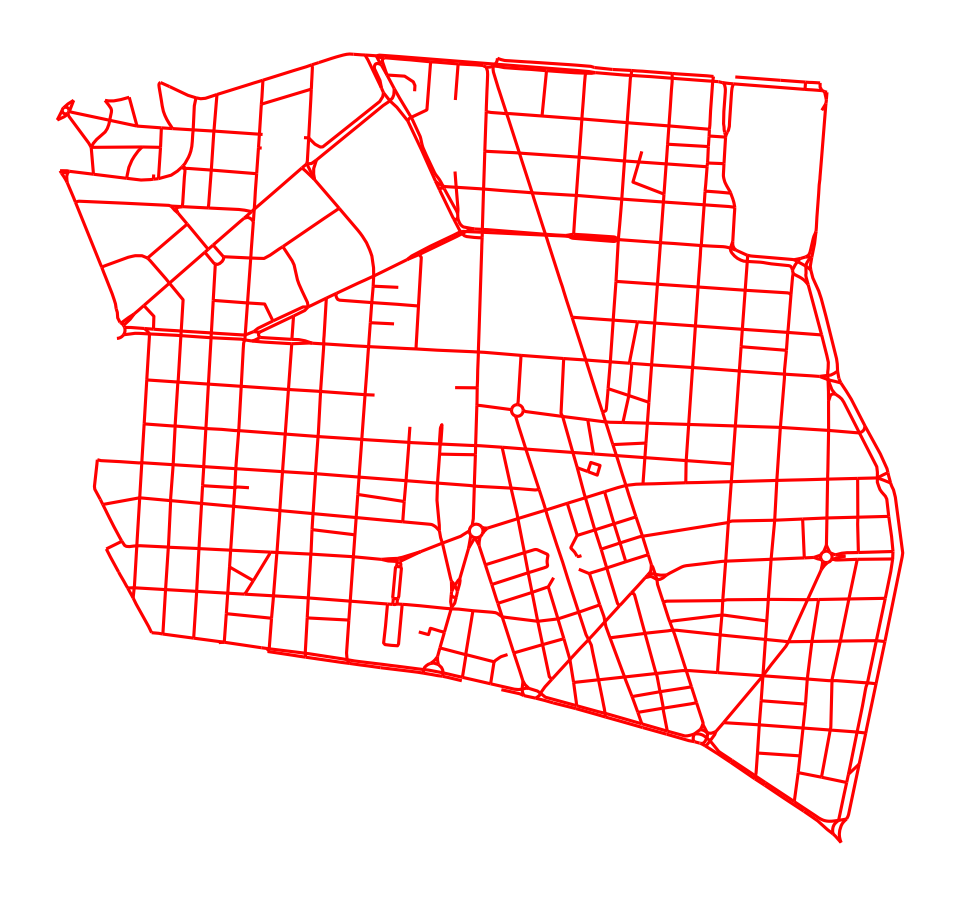

In [12]:
ax = edges.plot(figsize=(8, 12), color="red")
ax.set_axis_off()

In [ ]:
edges_output = momepy.roundabout_simplification(edges)

/home/lpsha/.conda/envs/umap-env/lib/python3.10/site-packages/momepy/preprocessing.py:771: FutureWarning: Class based API like `momepy.CircularCompactness` is deprecated. Replace it with `momepy.circular_compactness` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  circom_serie = CircularCompactness(gdf, area_col).series


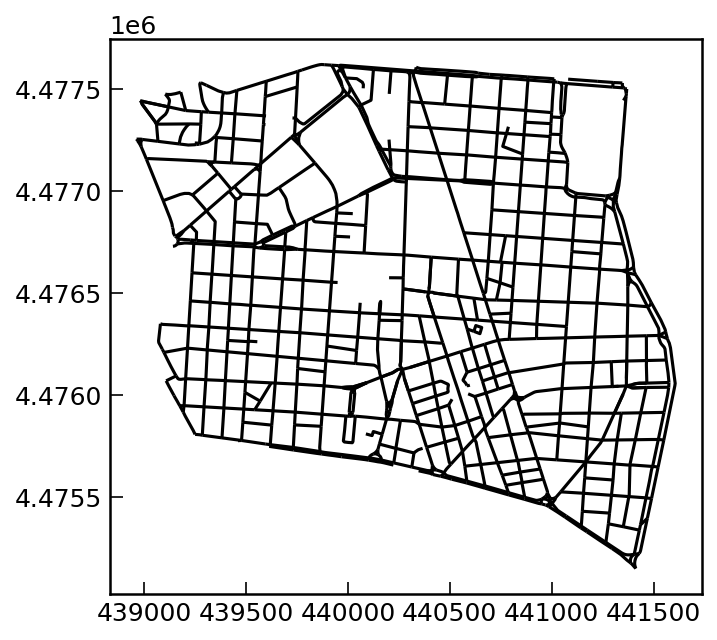

In [22]:
# ax = edges.plot(figsize=(8, 12), color="red")
edges_output.plot( color="black")
plt.show()
# ax.set_axis_off()